# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from pmdarima import auto_arima
from itertools import product 
from dash import Dash, dcc, html, Input, Output

# Read Data

In [2]:
# Patient-level
line_list = pd.read_csv(r"data/COVID19_line_list_data.csv")
open_line_list = pd.read_csv(r"data/COVID19_open_line_list.csv")

# Country-level
Countries = pd.read_csv(r"data/countries of the world.csv")

# Daily COVID
covid_daily = pd.read_csv(r"data/covid_19_data.csv")

# Time series COVID
confirmed = pd.read_csv(r"data/time_series_covid_19_confirmed.csv")
deaths = pd.read_csv(r"data/time_series_covid_19_deaths.csv")
recovered = pd.read_csv(r"data/time_series_covid_19_recovered.csv")

# Sars 2003 
Sars = pd.read_csv(r"data/sars_2003_complete_dataset_clean.csv")

# Data Overview

## Line List Data

In [3]:
line_list.head()

id  case_in_country reporting date  Unnamed: 3  \
0   1              NaN      1/20/2020         NaN   
1   2              NaN      1/20/2020         NaN   
2   3              NaN      1/21/2020         NaN   
3   4              NaN      1/21/2020         NaN   
4   5              NaN      1/21/2020         NaN   

                                             summary             location  \
0  First confirmed imported COVID-19 pneumonia pa...  Shenzhen, Guangdong   
1  First confirmed imported COVID-19 pneumonia pa...             Shanghai   
2  First confirmed imported cases in Zhejiang: pa...             Zhejiang   
3  new confirmed imported COVID-19 pneumonia in T...              Tianjin   
4  new confirmed imported COVID-19 pneumonia in T...              Tianjin   

  country  gender   age symptom_onset  ...  recovered symptom  \
0   China    male  66.0      01/03/20  ...          0     NaN   
1   China  female  56.0     1/15/2020  ...          0     NaN   
2   China    male  46.0      01/04/20  ...          0     NaN   
3   China  female  60.0           NaN  ...          0     NaN   
4   China    male  58.0           NaN  ...          0     NaN   

                                              source  \
0               Shenzhen Municipal Health Commission   
1  Official Weibo of Shanghai Municipal Health Co...   
2             Health Commission of Zhejiang Province   
3                                           人民日报官方微博   
4                                           人民日报官方微博   

                                                link  Unnamed: 21  \
0  http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...          NaN   
1  https://www.weibo.com/2372649470/IqogQhgfa?fro...          NaN   
2  http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...          NaN   
3        https://m.weibo.cn/status/4463235401268457?          NaN   
4        https://m.weibo.cn/status/4463235401268457?          NaN   

   Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25 Unnamed: 26  
0          NaN         NaN         NaN         NaN         NaN  
1          NaN         NaN         NaN         NaN         NaN  
2          NaN         NaN         NaN         NaN         NaN  
3          NaN         NaN         NaN         NaN         NaN  
4          NaN         NaN         NaN         NaN         NaN  

[5 rows x 27 columns]

### 📑 COVID-19 Dataset – Column Explanations

| Column                | Description                                                                 | Expected Data Type |
|------------------------|-----------------------------------------------------------------------------|--------------------|
| **id**                | Unique identifier for each case                                             | Integer            |
| **case_in_country**    | Case number within the country                                              | Integer            |
| **reporting_date**     | Date when the case was officially reported                                  | Date               |
| **summary**            | Short text summary of the case                                              | String/Text        |
| **location**           | City or region where the case was reported                                  | String             |
| **country**            | Country where the case was reported                                         | String             |
| **gender**             | Gender of the patient (Male/Female/Unknown)                                 | String             |
| **age**                | Age of the patient                                                          | Integer            |
| **symptom_onset**      | Date when symptoms started                                                  | Date               |
| **If_onset_approximated** | Indicates if symptom onset date is exact or estimated                    | Boolean/String     |
| **hosp_visit_date**    | Date when patient visited hospital                                          | Date               |
| **exposure_start**     | Start date of possible exposure to the virus                                | Date               |
| **exposure_end**       | End date of possible exposure                                               | Date               |
| **visiting_Wuhan**     | Whether the patient visited Wuhan (Yes/No)                                  | Boolean            |
| **from_Wuhan**         | Whether the patient came from Wuhan (Yes/No)                                | Boolean            |
| **death**              | Whether the patient died (1/0 or Yes/No)                                    | Integer/Boolean    |
| **recovered**          | Whether the patient recovered (1/0 or Yes/No)                               | Integer/Boolean    |
| **symptom**            | Reported symptoms (e.g., fever, cough, pneumonia)                           | String/Text        |
| **source**             | Source of information (e.g., Health Ministry, WHO, media)                   | String             |
| **link**               | URL linking to original report/article                                      | String (URL)       |
| **Unnamed: 3, 21–26**  | Empty / unused columns (should be dropped)                                  | -                  |


In [4]:
line_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

### From this information  
- #### Data Cleaning Steps

1. **Drop unnecessary columns**  
   Remove columns that contain no data:  
   - Index **3, 21, 22, 23, 24, 25, 26**

2. **Convert columns to integer type**  
   - `age`
   - `from_wuhan`    

----

In [5]:
line_list.describe()

id  case_in_country  Unnamed: 3         age  \
count  1085.000000       888.000000         0.0  843.000000   
mean    543.000000        48.841216         NaN   49.483689   
std     313.356825        78.853528         NaN   18.255334   
min       1.000000         1.000000         NaN    0.250000   
25%     272.000000        11.000000         NaN   35.000000   
50%     543.000000        28.000000         NaN   51.000000   
75%     814.000000        67.250000         NaN   64.000000   
max    1085.000000      1443.000000         NaN   96.000000   

       If_onset_approximated  visiting Wuhan   from Wuhan  Unnamed: 21  \
count             560.000000     1085.000000  1081.000000          0.0   
mean                0.042857        0.176959     0.144311          NaN   
std                 0.202716        0.381810     0.351567          NaN   
min                 0.000000        0.000000     0.000000          NaN   
25%                 0.000000        0.000000     0.000000          NaN   
50%                 0.000000        0.000000     0.000000          NaN   
75%                 0.000000        0.000000     0.000000          NaN   
max                 1.000000        1.000000     1.000000          NaN   

       Unnamed: 22  Unnamed: 23  Unnamed: 24  Unnamed: 25  Unnamed: 26  
count          0.0          0.0          0.0          0.0          0.0  
mean           NaN          NaN          NaN          NaN          NaN  
std            NaN          NaN          NaN          NaN          NaN  
min            NaN          NaN          NaN          NaN          NaN  
25%            NaN          NaN          NaN          NaN          NaN  
50%            NaN          NaN          NaN          NaN          NaN  
75%            NaN          NaN          NaN          NaN          NaN  
max            NaN          NaN          NaN          NaN          NaN

---

### Data Cleaning

**First drop `unuseful columns`**

In [6]:
line_list.drop(columns=["Unnamed: 3","Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25","Unnamed: 26"],inplace=True)

**standardize column names so that instead of spaces, every column uses snake_case**

In [7]:
line_list.columns = line_list.columns.str.strip().str.lower().str.replace(" ", "_")

### Handling NULLs

In [8]:
line_list.isna().sum()

id                         0
case_in_country          197
reporting_date             1
summary                    5
location                   0
country                    0
gender                   183
age                      242
symptom_onset            522
if_onset_approximated    525
hosp_visit_date          578
exposure_start           957
exposure_end             744
visiting_wuhan             0
from_wuhan                 4
death                      0
recovered                  0
symptom                  815
source                     0
link                       0
dtype: int64

In [9]:
line_list.isna().mean()*100

id                        0.000000
case_in_country          18.156682
reporting_date            0.092166
summary                   0.460829
location                  0.000000
country                   0.000000
gender                   16.866359
age                      22.304147
symptom_onset            48.110599
if_onset_approximated    48.387097
hosp_visit_date          53.271889
exposure_start           88.202765
exposure_end             68.571429
visiting_wuhan            0.000000
from_wuhan                0.368664
death                     0.000000
recovered                 0.000000
symptom                  75.115207
source                    0.000000
link                      0.000000
dtype: float64

**Handling `case_in_country` Column**

- The `case_in_country` column represents the **sequential case number within each country**, assigned in the order cases were reported.  
- Since this numbering is specific and sequential, it cannot be filled with arbitrary values.  
- For the purpose of **analysis and dashboard building**, missing values (`NaN`) will be replaced with **"unknown"**.
- For **Prediction** i will drop this NANs


**Handling other Columns**

- **`summary`**, **`reporting_date`**, **`from_wuhan`**  
  → Contain only a small number of NULLs → **drop rows with missing values**.  

- **`gender`**  
  → Cannot be filled with arbitrary values → **replace missing values with `Unknown`**.  

- **`age`**  
  → Fill missing values using the **average age per country**.  

- **`symptom_onset`**, **`if_onset_approximated`**, **`hosp_visit_date`**  
  → Replace missing values with **"Unknown"**.  

- **`exposure_start`**, **`symptom`**, **`exposure_end`**  
  → Contain a high number of missing values → **drop these columns**.


In [10]:
# 1. Drop rows where summary, reporting_date, or from_wuhan are NULL
line_list = line_list.dropna(subset=["summary", "reporting_date", "from_wuhan"]).copy()

# 2. Fill missing values in age with the average age of each country
line_list.loc[:, "age"] = line_list.groupby("country")["age"].transform(
    lambda x: x.fillna(x.mean())
)

# 3. Replace NULLs in symptom_onset, if_onset_approximated, hosp_visit_date, gender with "Unknown"
line_list.loc[:, ["symptom_onset", "if_onset_approximated", "hosp_visit_date", "gender","case_in_country"]] = (
    line_list[["symptom_onset", "if_onset_approximated", "hosp_visit_date", "gender","case_in_country"]].fillna("Unknown")
)

# 4. Drop columns with high NULLs: exposure_start, symptom, exposure_end
line_list = line_list.drop(columns=["exposure_start", "symptom", "exposure_end"]).copy()


In [11]:
line_list.isna().sum()

id                        0
case_in_country           0
reporting_date            0
summary                   0
location                  0
country                   0
gender                    0
age                      54
symptom_onset             0
if_onset_approximated     0
hosp_visit_date           0
visiting_wuhan            0
from_wuhan                0
death                     0
recovered                 0
source                    0
link                      0
dtype: int64

**Some countries have all missing ages → so the mean for that country is also NaN.**<br>
**i will fill with overall mean age**

In [12]:
line_list.loc[:, "age"] = line_list["age"].fillna(line_list["age"].mean())

In [13]:
line_list.isna().sum()

id                       0
case_in_country          0
reporting_date           0
summary                  0
location                 0
country                  0
gender                   0
age                      0
symptom_onset            0
if_onset_approximated    0
hosp_visit_date          0
visiting_wuhan           0
from_wuhan               0
death                    0
recovered                0
source                   0
link                     0
dtype: int64

----

### Handling Data Types

In [14]:
to_convert_int = ["age","from_wuhan"] # list contain columns that will be converted to int

In [15]:
line_list[to_convert_int] = line_list[to_convert_int].apply(pd.to_numeric, errors="coerce").astype("int") # convert columns to int

In [16]:
line_list.dtypes

id                        int64
case_in_country          object
reporting_date           object
summary                  object
location                 object
country                  object
gender                   object
age                       int32
symptom_onset            object
if_onset_approximated    object
hosp_visit_date          object
visiting_wuhan            int64
from_wuhan                int32
death                    object
recovered                object
source                   object
link                     object
dtype: object

---

## open_line_list

In [17]:
open_line_list.head()

ID age     sex                        city province country  \
0  1.0  30    male     Chaohu City, Hefei City    Anhui   China   
1  2.0  47    male  Baohe District, Hefei City    Anhui   China   
2  3.0  49    male  High-Tech Zone, Hefei City    Anhui   China   
3  4.0  47  female  High-Tech Zone, Hefei City    Anhui   China   
4  5.0  50  female  Feidong County, Hefei City    Anhui   China   

   wuhan(0)_not_wuhan(1)   latitude   longitude geo_resolution  ...  \
0                    1.0  31.646960  117.716600         admin3  ...   
1                    1.0  31.778630  117.331900         admin3  ...   
2                    1.0  31.828313  117.224844          point  ...   
3                    1.0  31.828313  117.224844          point  ...   
4                    1.0  32.001230  117.568100         admin3  ...   

  Unnamed: 35 Unnamed: 36 Unnamed: 37 Unnamed: 38 Unnamed: 39 Unnamed: 40  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 41 Unnamed: 42 Unnamed: 43  Unnamed: 44  
0         NaN         NaN         NaN          NaN  
1         NaN         NaN         NaN          NaN  
2         NaN         NaN         NaN          NaN  
3         NaN         NaN         NaN          NaN  
4         NaN         NaN         NaN          NaN  

[5 rows x 45 columns]

In [18]:
open_line_list.shape

(14126, 45)

In [19]:
open_line_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        13173 non-null  float64
 1   age                       1349 non-null   object 
 2   sex                       1264 non-null   object 
 3   city                      10194 non-null  object 
 4   province                  12906 non-null  object 
 5   country                   13148 non-null  object 
 6   wuhan(0)_not_wuhan(1)     13170 non-null  float64
 7   latitude                  13147 non-null  float64
 8   longitude                 13147 non-null  float64
 9   geo_resolution            13147 non-null  object 
 10  date_onset_symptoms       746 non-null    object 
 11  date_admission_hospital   730 non-null    object 
 12  date_confirmation         13089 non-null  object 
 13  symptoms                  493 non-null    object 
 14  lives_

In [20]:
open_line_list.describe()

ID  wuhan(0)_not_wuhan(1)      latitude     longitude  \
count  13173.000000                13170.0  13147.000000  13147.000000   
mean    6769.250436                    1.0     31.994650    110.495353   
std     3920.886020                    0.0      7.536335     27.985144   
min        1.000000                    1.0    -37.813600   -124.953070   
25%     3351.000000                    1.0     27.905380    111.729600   
50%     6865.000000                    1.0     31.759410    115.441800   
75%    10180.000000                    1.0     35.781340    120.440400   
max    13479.000000                    1.0     69.649468    153.400000   

       chronic_disease_binary  Unnamed: 33  Unnamed: 34  Unnamed: 35  \
count               18.000000          0.0          0.0          0.0   
mean                 0.722222          NaN          NaN          NaN   
std                  0.460889          NaN          NaN          NaN   
min                  0.000000          NaN          NaN          NaN   
25%                  0.250000          NaN          NaN          NaN   
50%                  1.000000          NaN          NaN          NaN   
75%                  1.000000          NaN          NaN          NaN   
max                  1.000000          NaN          NaN          NaN   

       Unnamed: 36  Unnamed: 37  Unnamed: 38  Unnamed: 39  Unnamed: 40  \
count          0.0          0.0          0.0          0.0          0.0   
mean           NaN          NaN          NaN          NaN          NaN   
std            NaN          NaN          NaN          NaN          NaN   
min            NaN          NaN          NaN          NaN          NaN   
25%            NaN          NaN          NaN          NaN          NaN   
50%            NaN          NaN          NaN          NaN          NaN   
75%            NaN          NaN          NaN          NaN          NaN   
max            NaN          NaN          NaN          NaN          NaN   

       Unnamed: 41  Unnamed: 42  Unnamed: 43  Unnamed: 44  
count          0.0          0.0          0.0          0.0  
mean           NaN          NaN          NaN          NaN  
std            NaN          NaN          NaN          NaN  
min            NaN          NaN          NaN          NaN  
25%            NaN          NaN          NaN          NaN  
50%            NaN          NaN          NaN          NaN  
75%            NaN          NaN          NaN          NaN  
max            NaN          NaN          NaN          NaN

### Data Cleaning

In [21]:
open_line_list.drop(columns=["Unnamed: 33","Unnamed: 34","Unnamed: 35","Unnamed: 36","Unnamed: 37","Unnamed: 38","Unnamed: 39","Unnamed: 40","Unnamed: 41","Unnamed: 42","Unnamed: 43","Unnamed: 44"],
                   inplace = True)

### Handling NULLs

In [22]:
open_line_list.isna().sum()

ID                            953
age                         12777
sex                         12862
city                         3932
province                     1220
country                       978
wuhan(0)_not_wuhan(1)         956
latitude                      979
longitude                     979
geo_resolution                979
date_onset_symptoms         13380
date_admission_hospital     13396
date_confirmation            1037
symptoms                    13633
lives_in_Wuhan              13561
travel_history_dates        13623
travel_history_location     13369
reported_market_exposure    14091
additional_information      11714
chronic_disease_binary      14108
chronic_disease             14113
source                       1176
sequence_available          14125
outcome                     13942
date_death_or_discharge     14033
notes_for_discussion        13939
location                    13102
admin3                      12967
admin2                       5058
admin1        

In [23]:
open_line_list.isna().mean()*100

ID                           6.746425
age                         90.450234
sex                         91.051961
city                        27.835198
province                     8.636557
country                      6.923404
wuhan(0)_not_wuhan(1)        6.767662
latitude                     6.930483
longitude                    6.930483
geo_resolution               6.930483
date_onset_symptoms         94.718958
date_admission_hospital     94.832224
date_confirmation            7.341073
symptoms                    96.509982
lives_in_Wuhan              96.000283
travel_history_dates        96.439190
travel_history_location     94.641087
reported_market_exposure    99.752230
additional_information      82.925103
chronic_disease_binary      99.872575
chronic_disease             99.907971
source                       8.325074
sequence_available          99.992921
outcome                     98.697437
date_death_or_discharge     99.341640
notes_for_discussion        98.676200
location    

**There are a lot of columns contain NULLs > 90 % --> drop these columns**

In [24]:
for i in open_line_list.columns:
    if open_line_list[i].isna().mean()*100 > 80:
        open_line_list.drop(columns=[i],inplace = True)

In [25]:
open_line_list.isna().mean()*100

ID                        6.746425
city                     27.835198
province                  8.636557
country                   6.923404
wuhan(0)_not_wuhan(1)     6.767662
latitude                  6.930483
longitude                 6.930483
geo_resolution            6.930483
date_confirmation         7.341073
source                    8.325074
admin2                   35.806315
admin1                    8.841852
country_new               7.411865
admin_id                  7.241965
dtype: float64

### Handling Missing Data (Geographic & Source Information)

- **`city`**, **`country`**, **`source`**, **`admin1`**, **`admin2`**  
  → Replace missing values (`NaN`) with **"Unknown"**.  

- **`latitude`**, **`longitude`**, **`geo_resolution`**, **`date_confirmation`**,  
  **`country_new`**, **`admin_id`**, **`ID`**, **`wuhan(0)_not_wuhan(1)`**, **`province`**  
  → Contain critical location or identifier data → **drop rows with missing values**.
n

In [26]:
to_replace_unknown = ["city","country","source","admin1","admin2"]
to_drop_NANs = ["latitude","longitude","geo_resolution","date_confirmation",
                "date_confirmation","ID","country_new","admin_id","wuhan(0)_not_wuhan(1)","province"]

In [27]:
def replace_with_unknown(list,df):
    for i in list:
        df.replace({i:{np.nan:"unknown"}},inplace = True)

In [28]:
open_line_list.replace({"admin1":{np.nan:"unknown"}},inplace = True)

In [29]:
replace_with_unknown(to_replace_unknown,open_line_list)

In [30]:
open_line_list.dropna(subset=to_drop_NANs,inplace = True)

----

## Covid Daily

In [31]:
covid_daily.head()

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

### 📑 COVID-19 Daily 

| Column            | Description                                                                 | Expected Data Type |
|--------------------|-----------------------------------------------------------------------------|--------------------|
| **SNo**           | Serial number (row index in the dataset). Not useful for analysis.           | Integer            |
| **ObservationDate** | The date when the data was recorded/reported.                              | Date               |
| **Province/State** | State, province, or region within a country. May be NULL for some countries.| String             |
| **Country/Region** | The country name (e.g., China, Italy, United States).                       | String             |
| **Last Update**    | The last time this row’s data was updated (date + time).                    | Date/Datetime      |
| **Confirmed**      | Cumulative number of confirmed COVID-19 cases up to that date.              | Integer            |
| **Deaths**         | Cumulative number of deaths due to COVID-19 up to that date.                | Integer            |
| **Recovered**      | Cumulative number of recovered cases up to that date.                       | Integer            |


In [32]:
covid_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              5632 non-null   int64  
 1   ObservationDate  5632 non-null   object 
 2   Province/State   3453 non-null   object 
 3   Country/Region   5632 non-null   object 
 4   Last Update      5632 non-null   object 
 5   Confirmed        5632 non-null   float64
 6   Deaths           5632 non-null   float64
 7   Recovered        5632 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 352.1+ KB


---

### Handling NULLs

In [33]:
covid_daily.isna().mean()*100

SNo                 0.000000
ObservationDate     0.000000
Province/State     38.689631
Country/Region      0.000000
Last Update         0.000000
Confirmed           0.000000
Deaths              0.000000
Recovered           0.000000
dtype: float64

In [34]:
replace_with_unknown(["Province/State"],covid_daily) # replace NANs with unknown
covid_daily.drop(columns=["Last Update"],inplace = True)

### Handling Data Types

In [35]:
def to_int(cols, df):
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

def to_datetime(cols,df):
    for col in cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")  

In [36]:
to_int(["Confirmed","Deaths","Recovered"],covid_daily)

In [37]:
to_datetime(["ObservationDate"],covid_daily)

----

## Confirmed dataset

In [38]:
confirmed.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        2        3        5   
1            NaN          Japan  36.0000  138.0000        2        1        2   
2            NaN      Singapore   1.2833  103.8333        0        1        3   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0        7        8        8  ...      47      48      50      50      50   
1        2        4        4  ...     360     420     461     502     511   
2        3        4        5  ...     117     130     138     150     150   
3        1        1        1  ...       1       1       1       1       1   
4        3        4        4  ...      50      83      93      99     117   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  
0       53       59       70       75       82  
1      581      639      639      701      773  
2      160      178      178      200      212  
3        1        1        1        1        1  
4      129      149      149      197      238  

[5 rows x 57 columns]

In [39]:
confirmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  307 non-null    object 
 1   Country/Region  442 non-null    object 
 2   Lat             442 non-null    float64
 3   Long            442 non-null    float64
 4   1/22/20         442 non-null    int64  
 5   1/23/20         442 non-null    int64  
 6   1/24/20         442 non-null    int64  
 7   1/25/20         442 non-null    int64  
 8   1/26/20         442 non-null    int64  
 9   1/27/20         442 non-null    int64  
 10  1/28/20         442 non-null    int64  
 11  1/29/20         442 non-null    int64  
 12  1/30/20         442 non-null    int64  
 13  1/31/20         442 non-null    int64  
 14  2/1/20          442 non-null    int64  
 15  2/2/20          442 non-null    int64  
 16  2/3/20          442 non-null    int64  
 17  2/4/20          442 non-null    int

In [40]:
confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    32.472246  -38.240308    1.255656    1.477376    2.128959    3.244344   
std     18.243160   80.488626   21.171051   21.257000   26.477289   36.865436   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     29.517325  -94.614125    0.000000    0.000000    0.000000    0.000000   
50%     38.194900  -75.247900    0.000000    0.000000    0.000000    0.000000   
75%     42.328900   18.981425    0.000000    0.000000    0.000000    0.000000   
max     64.963100  174.886000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...        3/5/20  \
count   442.000000   442.000000   442.000000   442.000000  ...    442.000000   
mean      4.791855     6.622172    12.619910    13.950226  ...    221.452489   
std      51.533686    69.443788   170.220759   171.323903  ...   3231.736307   
min       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
25%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
50%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
75%       0.000000     0.000000     0.000000     0.000000  ...      2.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  ...  67466.000000   

             3/6/20        3/7/20        3/8/20        3/9/20       3/10/20  \
count    442.000000    442.000000    442.000000    442.000000    442.000000   
mean     230.280543    239.414027    248.404977    256.925339    268.307692   
std     3245.454795   3259.270219   3272.375630   3287.815469   3300.662870   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      1.000000      0.000000   
75%        3.000000      4.000000      6.000000      7.000000      8.750000   
max    67592.000000  67666.000000  67707.000000  67743.000000  67760.000000   

            3/11/20       3/12/20       3/13/20       3/14/20  
count    442.000000    442.000000    442.000000    442.000000  
mean     284.762443    290.368778    328.490950    353.171946  
std     3327.040627   3334.956867   3408.758787   3472.648781  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      1.000000      1.000000  
75%       11.750000     17.000000     25.750000     30.750000  
max    67773.000000  67781.000000  67786.000000  67790.000000  

[8 rows x 55 columns]

### Handling NULLs

In [41]:
confirmed.isna().sum()

Province/State    135
Country/Region      0
Lat                 0
Long                0
1/22/20             0
1/23/20             0
1/24/20             0
1/25/20             0
1/26/20             0
1/27/20             0
1/28/20             0
1/29/20             0
1/30/20             0
1/31/20             0
2/1/20              0
2/2/20              0
2/3/20              0
2/4/20              0
2/5/20              0
2/6/20              0
2/7/20              0
2/8/20              0
2/9/20              0
2/10/20             0
2/11/20             0
2/12/20             0
2/13/20             0
2/14/20             0
2/15/20             0
2/16/20             0
2/17/20             0
2/18/20             0
2/19/20             0
2/20/20             0
2/21/20             0
2/22/20             0
2/23/20             0
2/24/20             0
2/25/20             0
2/26/20             0
2/27/20             0
2/28/20             0
2/29/20             0
3/1/20              0
3/2/20              0
3/3/20    

In [42]:
confirmed.drop(columns = ["Province/State"],inplace = True)

In [43]:
confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    32.472246  -38.240308    1.255656    1.477376    2.128959    3.244344   
std     18.243160   80.488626   21.171051   21.257000   26.477289   36.865436   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     29.517325  -94.614125    0.000000    0.000000    0.000000    0.000000   
50%     38.194900  -75.247900    0.000000    0.000000    0.000000    0.000000   
75%     42.328900   18.981425    0.000000    0.000000    0.000000    0.000000   
max     64.963100  174.886000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...        3/5/20  \
count   442.000000   442.000000   442.000000   442.000000  ...    442.000000   
mean      4.791855     6.622172    12.619910    13.950226  ...    221.452489   
std      51.533686    69.443788   170.220759   171.323903  ...   3231.736307   
min       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
25%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
50%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
75%       0.000000     0.000000     0.000000     0.000000  ...      2.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  ...  67466.000000   

             3/6/20        3/7/20        3/8/20        3/9/20       3/10/20  \
count    442.000000    442.000000    442.000000    442.000000    442.000000   
mean     230.280543    239.414027    248.404977    256.925339    268.307692   
std     3245.454795   3259.270219   3272.375630   3287.815469   3300.662870   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      1.000000      0.000000   
75%        3.000000      4.000000      6.000000      7.000000      8.750000   
max    67592.000000  67666.000000  67707.000000  67743.000000  67760.000000   

            3/11/20       3/12/20       3/13/20       3/14/20  
count    442.000000    442.000000    442.000000    442.000000  
mean     284.762443    290.368778    328.490950    353.171946  
std     3327.040627   3334.956867   3408.758787   3472.648781  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      1.000000      1.000000  
75%       11.750000     17.000000     25.750000     30.750000  
max    67773.000000  67781.000000  67786.000000  67790.000000  

[8 rows x 55 columns]

In [44]:
confirmed.shape

(442, 56)

----

## deaths dataset

In [45]:
deaths.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0        0        0        0  ...       1       1       1       1       1   
1        0        0        0  ...       6       6       6       6      10   
2        0        0        0  ...       0       0       0       0       0   
3        0        0        0  ...       0       0       0       0       0   
4        0        0        0  ...       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  
0        1        1        1        1        1  
1       10       15       16       19       22  
2        0        0        0        0        0  
3        0        0        0        0        0  
4        0        0        0        0        0  

[5 rows x 57 columns]

In [46]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  307 non-null    object 
 1   Country/Region  442 non-null    object 
 2   Lat             442 non-null    float64
 3   Long            442 non-null    float64
 4   1/22/20         442 non-null    int64  
 5   1/23/20         442 non-null    int64  
 6   1/24/20         442 non-null    int64  
 7   1/25/20         442 non-null    int64  
 8   1/26/20         442 non-null    int64  
 9   1/27/20         442 non-null    int64  
 10  1/28/20         442 non-null    int64  
 11  1/29/20         442 non-null    int64  
 12  1/30/20         442 non-null    int64  
 13  1/31/20         442 non-null    int64  
 14  2/1/20          442 non-null    int64  
 15  2/2/20          442 non-null    int64  
 16  2/3/20          442 non-null    int64  
 17  2/4/20          442 non-null    int

In [47]:
deaths.drop(columns = ["Province/State"],inplace = True)

In [48]:
deaths.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    32.472246  -38.240308    0.038462    0.040724    0.058824    0.095023   
std     18.243160   80.488626    0.808608    0.809898    1.143324    1.903576   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     29.517325  -94.614125    0.000000    0.000000    0.000000    0.000000   
50%     38.194900  -75.247900    0.000000    0.000000    0.000000    0.000000   
75%     42.328900   18.981425    0.000000    0.000000    0.000000    0.000000   
max     64.963100  174.886000   17.000000   17.000000   24.000000   40.000000   

          1/26/20    1/27/20     1/28/20     1/29/20  ...       3/5/20  \
count  442.000000  442.00000  442.000000  442.000000  ...   442.000000   
mean     0.126697    0.18552    0.296380    0.300905  ...     7.574661   
std      2.474773    3.61616    5.946125    5.946660  ...   138.276384   
min      0.000000    0.00000    0.000000    0.000000  ...     0.000000   
25%      0.000000    0.00000    0.000000    0.000000  ...     0.000000   
50%      0.000000    0.00000    0.000000    0.000000  ...     0.000000   
75%      0.000000    0.00000    0.000000    0.000000  ...     0.000000   
max     52.000000   76.00000  125.000000  125.000000  ...  2902.000000   

            3/6/20       3/7/20       3/8/20       3/9/20      3/10/20  \
count   442.000000   442.000000   442.000000   442.000000   442.000000   
mean      7.828054     8.049774     8.601810     9.022624     9.642534   
std     139.816814   141.307973   143.330153   145.125872   147.491508   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2931.000000  2959.000000  2986.000000  3008.000000  3024.000000   

           3/11/20      3/12/20      3/13/20      3/14/20  
count   442.000000   442.000000   442.000000   442.000000  
mean     10.441176    10.678733    12.226244    13.165158  
std     150.963459   151.851434   159.423717   164.161312  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max    3046.000000  3056.000000  3062.000000  3075.000000  

[8 rows x 55 columns]

----

## recovered dataset

In [49]:
recovered.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0        0        2        2  ...      31      31      31      31      31   
1        0        1        1  ...      43      46      76      76      76   
2        0        0        0  ...      78      78      78      78      78   
3        0        0        0  ...       1       1       1       1       1   
4        0        0        0  ...      22      22      23      24      24   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  
0       33       34       34       35       35  
1      101      118      118      118      118  
2       78       96       96       97      105  
3        1        1        1        1        1  
4       24       26       26       26       35  

[5 rows x 57 columns]

In [50]:
recovered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  307 non-null    object 
 1   Country/Region  442 non-null    object 
 2   Lat             442 non-null    float64
 3   Long            442 non-null    float64
 4   1/22/20         442 non-null    int64  
 5   1/23/20         442 non-null    int64  
 6   1/24/20         442 non-null    int64  
 7   1/25/20         442 non-null    int64  
 8   1/26/20         442 non-null    int64  
 9   1/27/20         442 non-null    int64  
 10  1/28/20         442 non-null    int64  
 11  1/29/20         442 non-null    int64  
 12  1/30/20         442 non-null    int64  
 13  1/31/20         442 non-null    int64  
 14  2/1/20          442 non-null    int64  
 15  2/2/20          442 non-null    int64  
 16  2/3/20          442 non-null    int64  
 17  2/4/20          442 non-null    int

In [51]:
recovered.drop(columns = ["Province/State"],inplace = True)

----

## Countries

In [52]:
Countries.head()

Country                               Region  Population  \
0     Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1         Albania   EASTERN EUROPE                          3581655   
2         Algeria   NORTHERN AFRICA                        32930091   
3  American Samoa   OCEANIA                                   57794   
4         Andorra   WESTERN EUROPE                            71201   

   Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0          647500                       48,0                         0,00   
1           28748                      124,6                         1,26   
2         2381740                       13,8                         0,04   
3             199                      290,4                        58,29   
4             468                      152,1                         0,00   

  Net migration Infant mortality (per 1000 births)  GDP ($ per capita)  \
0         23,06                             163,07               700.0   
1         -4,93                              21,52              4500.0   
2         -0,39                                 31              6000.0   
3        -20,71                               9,27              8000.0   
4           6,6                               4,05             19000.0   

  Literacy (%) Phones (per 1000) Arable (%) Crops (%) Other (%) Climate  \
0         36,0               3,2      12,13      0,22     87,65       1   
1         86,5              71,2      21,09      4,42     74,49       3   
2         70,0              78,1       3,22      0,25     96,53       1   
3         97,0             259,5         10        15        75       2   
4        100,0             497,2       2,22         0     97,78       3   

  Birthrate Deathrate Agriculture Industry Service  
0      46,6     20,34        0,38     0,24    0,38  
1     15,11      5,22       0,232    0,188   0,579  
2     17,14      4,61       0,101      0,6   0,298  
3     22,46      3,27         NaN      NaN     NaN  
4      8,71      6,25         NaN      NaN     NaN

In [53]:
Countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

In [54]:
Countries.describe()

Population  Area (sq. mi.)  GDP ($ per capita)
count  2.270000e+02    2.270000e+02          226.000000
mean   2.874028e+07    5.982270e+05         9689.823009
std    1.178913e+08    1.790282e+06        10049.138513
min    7.026000e+03    2.000000e+00          500.000000
25%    4.376240e+05    4.647500e+03         1900.000000
50%    4.786994e+06    8.660000e+04         5550.000000
75%    1.749777e+07    4.418110e+05        15700.000000
max    1.313974e+09    1.707520e+07        55100.000000

### Handling NULLs

In [55]:
Countries.isna().sum()

Country                                0
Region                                 0
Population                             0
Area (sq. mi.)                         0
Pop. Density (per sq. mi.)             0
Coastline (coast/area ratio)           0
Net migration                          3
Infant mortality (per 1000 births)     3
GDP ($ per capita)                     1
Literacy (%)                          18
Phones (per 1000)                      4
Arable (%)                             2
Crops (%)                              2
Other (%)                              2
Climate                               22
Birthrate                              3
Deathrate                              4
Agriculture                           15
Industry                              16
Service                               15
dtype: int64

In [56]:
Countries.dropna(inplace = True)

In [57]:
Countries.columns[3:]

Index(['Area (sq. mi.)', 'Pop. Density (per sq. mi.)',
       'Coastline (coast/area ratio)', 'Net migration',
       'Infant mortality (per 1000 births)', 'GDP ($ per capita)',
       'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)',
       'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture',
       'Industry', 'Service'],
      dtype='object')

In [58]:
Columns_Countries = Countries.columns[3:]
Columns_Countries

Index(['Area (sq. mi.)', 'Pop. Density (per sq. mi.)',
       'Coastline (coast/area ratio)', 'Net migration',
       'Infant mortality (per 1000 births)', 'GDP ($ per capita)',
       'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)',
       'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture',
       'Industry', 'Service'],
      dtype='object')

In [59]:
for col in Columns_Countries:
    Countries[col] = (
        Countries[col].astype(str).str.replace(",", ".").astype(float)
    )

## Sars

In [60]:
Sars.head()

Date               Country  Cumulative number of case(s)  \
0  2003-03-17               Germany                             1   
1  2003-03-17                Canada                             8   
2  2003-03-17             Singapore                            20   
3  2003-03-17  Hong Kong SAR, China                            95   
4  2003-03-17           Switzerland                             2   

   Number of deaths  Number recovered  
0                 0                 0  
1                 2                 0  
2                 0                 0  
3                 1                 0  
4                 0                 0

In [61]:
Sars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2538 entries, 0 to 2537
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          2538 non-null   object
 1   Country                       2538 non-null   object
 2   Cumulative number of case(s)  2538 non-null   int64 
 3   Number of deaths              2538 non-null   int64 
 4   Number recovered              2538 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 99.3+ KB


In [62]:
Sars["Date"]= pd.to_datetime(Sars["Date"])

In [63]:
Sars.describe()

Date  Cumulative number of case(s)  \
count                           2538                   2538.000000   
mean   2003-05-18 21:00:08.510638336                    219.211978   
min              2003-03-17 00:00:00                      0.000000   
25%              2003-04-24 00:00:00                      1.000000   
50%              2003-05-19 00:00:00                      3.000000   
75%              2003-06-13 00:00:00                     14.750000   
max              2003-07-11 00:00:00                   5329.000000   
std                              NaN                    825.024564   

       Number of deaths  Number recovered  
count       2538.000000       2538.000000  
mean          17.812845        134.678487  
min            0.000000          0.000000  
25%            0.000000          1.000000  
50%            0.000000          2.000000  
75%            2.000000          9.000000  
max          348.000000       4941.000000  
std           61.425627        581.595350

---

In [64]:
Countries.dropna(inplace = True)

**Now all datasets are ready for `analysis` and `visualization`**

## EDA

**Melt wide → long**

In [65]:
def melt_timeseries(df, value_name):
    df_melted = df.melt(id_vars=["Country/Region", "Lat", "Long"], 
                        var_name="Date", value_name=value_name)
    df_melted["Date"] = pd.to_datetime(df_melted["Date"])
    return df_melted

In [66]:
confirmed_long = melt_timeseries(confirmed, "Confirmed")
deaths_long = melt_timeseries(deaths, "Deaths")
recovered_long = melt_timeseries(recovered, "Recovered")

**Merge into one dataframe**


In [67]:
covid = confirmed_long.merge(deaths_long, on=["Country/Region","Lat","Long","Date"])
covid = covid.merge(recovered_long, on=["Country/Region","Lat","Long","Date"])
global_covid = covid.groupby("Date")[["Confirmed","Deaths","Recovered"]].sum().reset_index()

### Univariate Analysis

In [68]:
covid_daily["ObservationDate"].unique()

<DatetimeArray>
['2020-01-22 00:00:00', '2020-01-23 00:00:00', '2020-01-24 00:00:00',
 '2020-01-25 00:00:00', '2020-01-26 00:00:00', '2020-01-27 00:00:00',
 '2020-01-28 00:00:00', '2020-01-29 00:00:00', '2020-01-30 00:00:00',
 '2020-01-31 00:00:00', '2020-02-01 00:00:00', '2020-02-02 00:00:00',
 '2020-02-03 00:00:00', '2020-02-04 00:00:00', '2020-02-05 00:00:00',
 '2020-02-06 00:00:00', '2020-02-07 00:00:00', '2020-02-08 00:00:00',
 '2020-02-09 00:00:00', '2020-02-10 00:00:00', '2020-02-11 00:00:00',
 '2020-02-12 00:00:00', '2020-02-13 00:00:00', '2020-02-14 00:00:00',
 '2020-02-15 00:00:00', '2020-02-16 00:00:00', '2020-02-17 00:00:00',
 '2020-02-18 00:00:00', '2020-02-19 00:00:00', '2020-02-20 00:00:00',
 '2020-02-21 00:00:00', '2020-02-22 00:00:00', '2020-02-23 00:00:00',
 '2020-02-24 00:00:00', '2020-02-25 00:00:00', '2020-02-26 00:00:00',
 '2020-02-27 00:00:00', '2020-02-28 00:00:00', '2020-02-29 00:00:00',
 '2020-03-01 00:00:00', '2020-03-02 00:00:00', '2020-03-03 00:00:00',
 '20

**This data was recorded from 1/22/2020 to 3/14/2020, approximately two months.**

---

In [69]:
covid_daily["Province/State"].nunique()

260

**this dataset contain data of `259 State`**

---

In [70]:
covid_daily["Country/Region"].nunique()

156

**this dataset contain data of `156 Country/Region`**

----

---

**Getting the total number of people infected , deathed and recovered with COVID-19**

In [71]:
latest_date = covid_daily['ObservationDate'].max()

# Filter data for that date
latest_data = covid_daily[covid_daily['ObservationDate'] == latest_date]

# Total infected worldwide
total_confirmed = latest_data['Confirmed'].sum()
total_deaths = latest_data['Deaths'].sum()
total_recovered = latest_data['Recovered'].sum()

print("✅ Total confirmed cases:", total_confirmed)
print("☠️  Total deaths:", total_deaths)
print("💚 Total recovered:", total_recovered)

✅ Total confirmed cases: 156099
☠️  Total deaths: 5819
💚 Total recovered: 72624


---

In [72]:
country_totals = latest_data.groupby("Country/Region")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
top3_countries_confirmed = country_totals.sort_values(by="Confirmed", ascending=False).head(3)
top3_countries_confirmed = list(top3_countries_confirmed["Country/Region"])
top3_countries_confirmed

['Mainland China', 'Italy', 'Iran']

----

In [73]:
# Aggregate by date & country
covid_daily_grouped = covid_daily.groupby(['ObservationDate', 'Country/Region']).agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

### COVID-19 Trend with Dropdown Filter

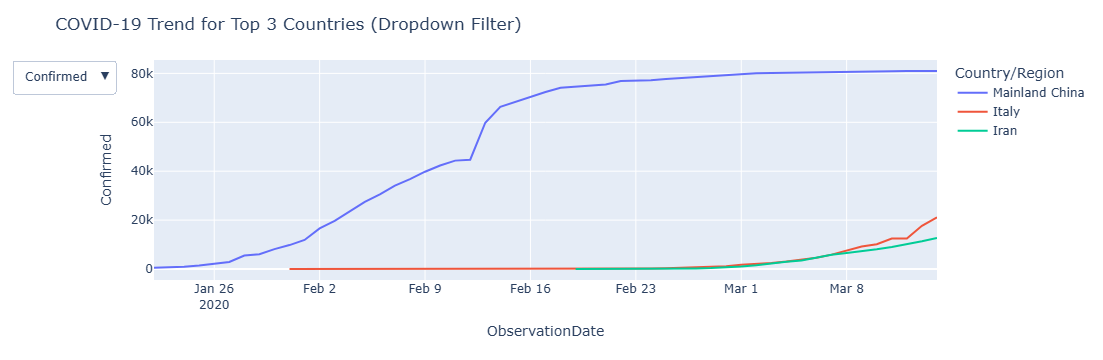

In [74]:

latest_date = covid_daily_grouped['ObservationDate'].max()
latest_data = covid_daily_grouped[covid_daily_grouped['ObservationDate'] == latest_date]

top3_countries_confirmed = (
    latest_data.sort_values(by="Confirmed", ascending=False)
    ['Country/Region'].head(3).tolist()
)

df_top3 = covid_daily_grouped[covid_daily_grouped['Country/Region'].isin(top3_countries_confirmed)]

fig_confirmed = px.line(df_top3, x="ObservationDate", y="Confirmed", color="Country/Region")
fig_deaths    = px.line(df_top3, x="ObservationDate", y="Deaths", color="Country/Region")
fig_recovered = px.line(df_top3, x="ObservationDate", y="Recovered", color="Country/Region")

fig_dropdown = fig_confirmed  # start with confirmed
fig_dropdown.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label="Confirmed",
                     method="update",
                     args=[{"y": [df_top3.pivot(index="ObservationDate", columns="Country/Region", values="Confirmed").values[:, i] 
                                   for i in range(len(top3_countries_confirmed))]}]),
                dict(label="Deaths",
                     method="update",
                     args=[{"y": [df_top3.pivot(index="ObservationDate", columns="Country/Region", values="Deaths").values[:, i] 
                                   for i in range(len(top3_countries_confirmed))]}]),
                dict(label="Recovered",
                     method="update",
                     args=[{"y": [df_top3.pivot(index="ObservationDate", columns="Country/Region", values="Recovered").values[:, i] 
                                   for i in range(len(top3_countries_confirmed))]}]),
            ]),
            direction="down",
            showactive=True
        )
    ],
    title="COVID-19 Trend for Top 3 Countries (Dropdown Filter)"
)

fig_dropdown.show()


### Covid - 19 Global Spread

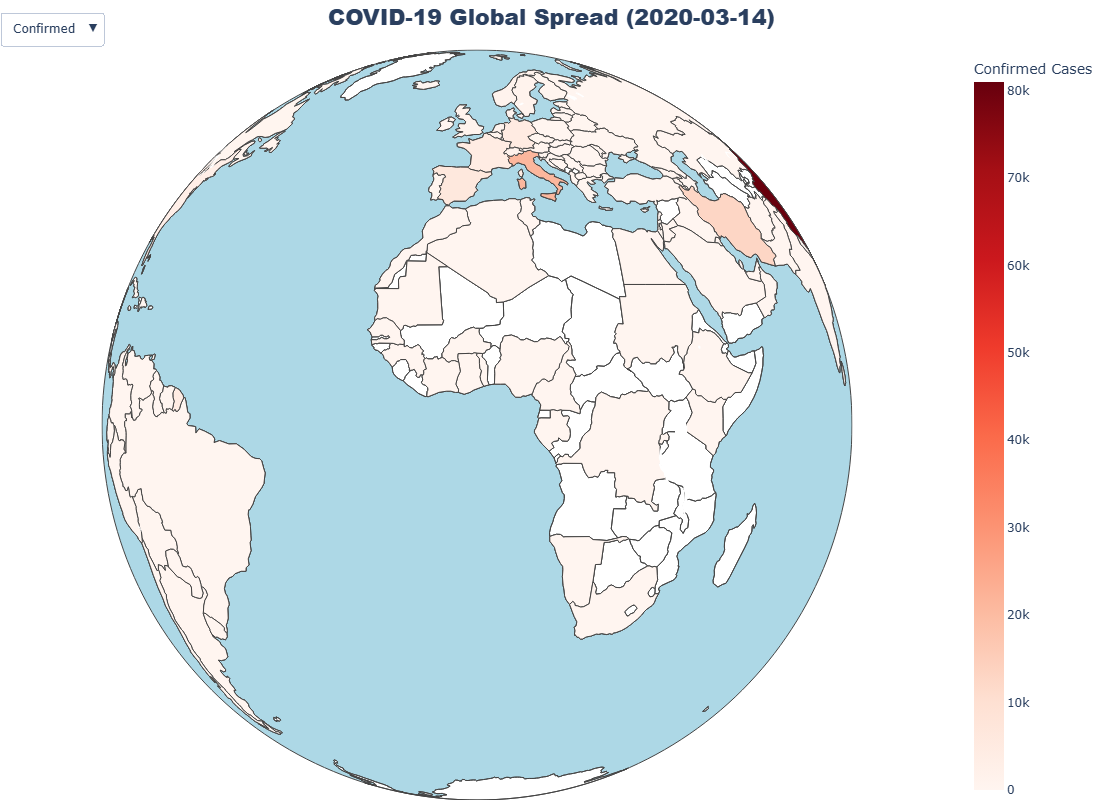

In [75]:
# Latest available data
latest = covid_daily_grouped[covid_daily_grouped['ObservationDate'] == covid_daily_grouped['ObservationDate'].max()]

# Start with Confirmed cases
fig_map = px.choropleth(
    latest,
    locations="Country/Region",
    locationmode="country names",
    color="Confirmed",
    hover_name="Country/Region",
    hover_data={
        "Confirmed": ":,",
        "Deaths": ":,",
        "Recovered": ":,"
    },
    color_continuous_scale="Reds",
    title=f"COVID-19 Global Spread ({latest['ObservationDate'].max().date()})"
)

# Globe appearance (make it look like a full ball)
fig_map.update_geos(
    projection_type="orthographic",
    showcoastlines=True,
    showcountries=True,
    showland=True,
    landcolor="white",
    oceancolor="lightblue",
    showocean=True,
    lataxis_showgrid=False,
    lonaxis_showgrid=False,
    resolution=110
)

# Center title and style
fig_map.update_layout(
    title_x=0.5,
    title_font=dict(size=22, family="Arial Black"),
    coloraxis_colorbar=dict(
        title="Confirmed Cases",
        titlefont=dict(size=14),
        tickfont=dict(size=12)
    )
)

# Dropdown menu to switch metrics
fig_map.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label="Confirmed",
                     method="restyle",
                     args=[{"z": [latest["Confirmed"]],
                            "colorscale": "Reds"}]),
                dict(label="Deaths",
                     method="restyle",
                     args=[{"z": [latest["Deaths"]],
                            "colorscale": "Greys"}]),
                dict(label="Recovered",
                     method="restyle",
                     args=[{"z": [latest["Recovered"]],
                            "colorscale": "Greens"}]),
            ]),
            direction="down",
            showactive=True,
            x=0.1, y=1.05
        )
    ]
)

fig_map.update_geos(
    projection_type="orthographic",
    showcoastlines=True,
    showcountries=True,
    showland=True,
    landcolor="white",
    oceancolor="lightblue",
    showocean=True,
    lataxis_showgrid=False,
    lonaxis_showgrid=False,
    resolution=110,
    domain=dict(x=[0,1], y=[0,1])  
)

fig_map.update_layout(
    autosize=True,
    width=800,   # increase figure width
    height=800,  # increase figure height (makes globe bigger)
    margin={"r":0,"t":50,"l":0,"b":0}  # remove extra white space
)
fig_map.show()


### COVID-19 Trend with Dropdown Filter with States and Covid-19 Spread Over Time

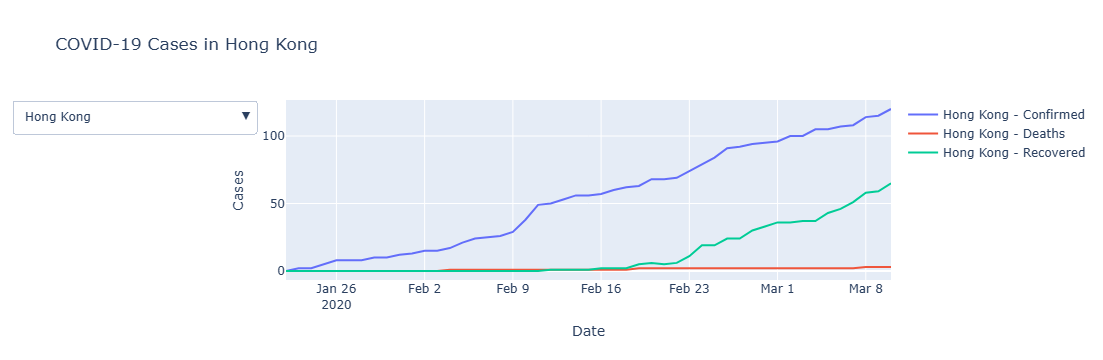

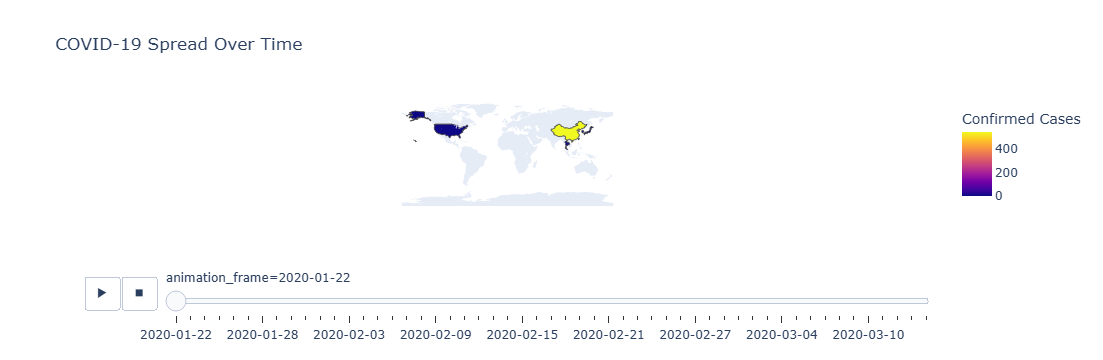

In [76]:
agg = covid_daily.groupby(["ObservationDate", "Country/Region"])[['Confirmed','Deaths','Recovered']].sum().reset_index()
countries = agg["Country/Region"].unique().tolist()

fig_line = go.Figure()

for c in countries:
    temp = agg[agg["Country/Region"] == c]
    fig_line.add_trace(go.Scatter(x=temp["ObservationDate"], y=temp["Confirmed"],
                                  mode="lines", name=f"{c} - Confirmed", visible=False))
    fig_line.add_trace(go.Scatter(x=temp["ObservationDate"], y=temp["Deaths"],
                                  mode="lines", name=f"{c} - Deaths", visible=False))
    fig_line.add_trace(go.Scatter(x=temp["ObservationDate"], y=temp["Recovered"],
                                  mode="lines", name=f"{c} - Recovered", visible=False))

# Start with first country visible
for i in range(3):
    fig_line.data[i].visible = True

# Dropdown menu
dropdown_buttons = []
for i, c in enumerate(countries):
    vis = [False] * (len(countries) * 3)
    vis[i*3:(i*3+3)] = [True, True, True]
    dropdown_buttons.append(dict(label=c,
                                 method="update",
                                 args=[{"visible": vis},
                                       {"title": f"COVID-19 in {c}"}]))

fig_line.update_layout(
    title=f"COVID-19 Cases in {countries[0]}",
    xaxis_title="Date",
    yaxis_title="Cases",
    updatemenus=[{"buttons": dropdown_buttons,
                  "direction": "down",
                  "showactive": True}]
)

fig_line.write_html("interactive_line_dropdown.html")
fig_line.show()

# --------------------------
# Global Choropleth with Date Slider
# --------------------------
fig_map = px.choropleth(
    agg,
    locations="Country/Region",
    locationmode="country names",
    color="Confirmed",
    hover_name="Country/Region",
    hover_data=["Deaths", "Recovered"],
    animation_frame=agg["ObservationDate"].dt.strftime("%Y-%m-%d"),
    title="COVID-19 Spread Over Time"
)

fig_map.update_layout(
    coloraxis_colorbar=dict(title="Confirmed Cases"),
    geo=dict(showframe=False, showcoastlines=False)
)

fig_map.write_html("interactive_global_map.html")
fig_map.show()


### 📈 COVID-19 Trend Insights

From all the visualizations, we can clearly see that:

- **COVID-19 cases increased significantly over time** across the globe.  
- The earliest and sharpest rises were observed in:
  - 🇨🇳 **China**  
  - 🇮🇹 **Italy**  
  - 🇮🇷 **Iran**  

These countries were among the first major hotspots of the pandemic.


----

### Highest number of new confirmed cases and new deaths reported in a single day.

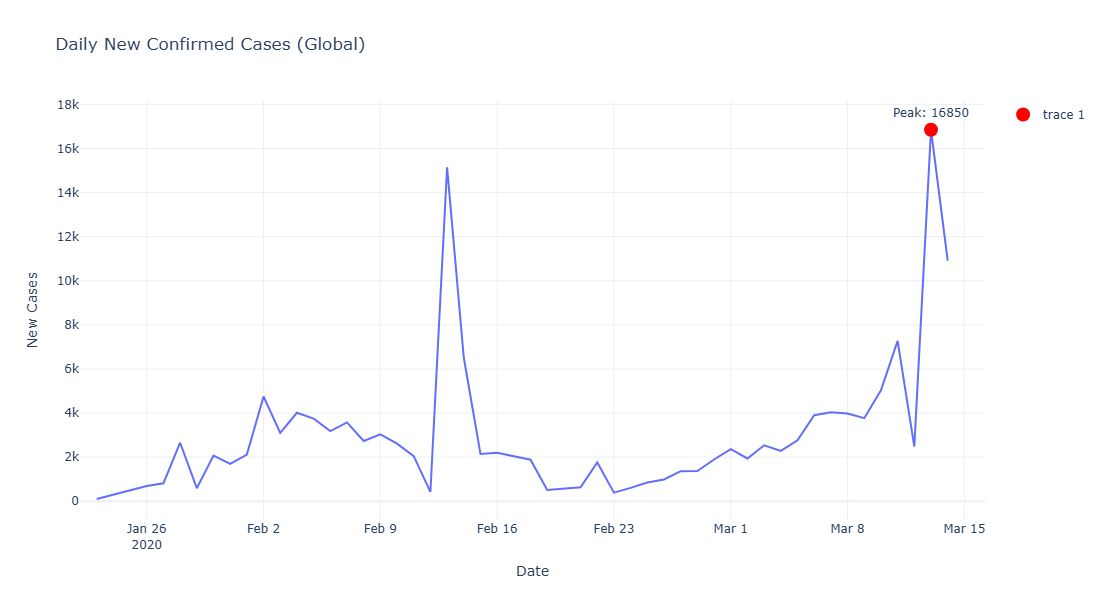

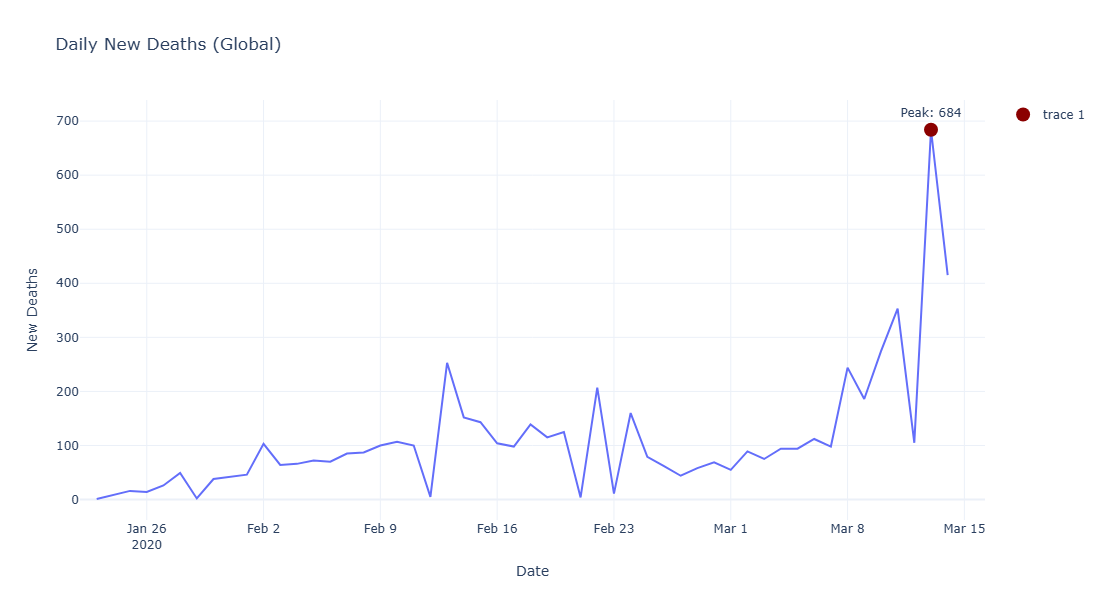

In [77]:
# Daily new values
daily_confirmed = global_covid["Confirmed"].diff()
daily_deaths = global_covid["Deaths"].diff()

# Peak values
peak_confirmed = daily_confirmed.max()
peak_deaths = daily_deaths.max()

# Peak dates
peak_date_confirmed = global_covid.loc[daily_confirmed.idxmax(), "Date"]
peak_date_deaths = global_covid.loc[daily_deaths.idxmax(), "Date"]

# Plot daily confirmed cases
fig_cases = px.line(
    x=global_covid["Date"], 
    y=daily_confirmed, 
    title="Daily New Confirmed Cases (Global)",
    labels={"x": "Date", "y": "New Cases"},
    template="plotly_white",
    width=1000,
    height=600
)

fig_cases.add_scatter(
    x=[peak_date_confirmed], 
    y=[peak_confirmed],
    mode="markers+text",
    text=[f"Peak: {int(peak_confirmed)}"],
    textposition="top center",
    marker=dict(size=14, color="red")
)
fig_cases.show()

# Plot daily deaths
fig_deaths = px.line(
    x=global_covid["Date"], 
    y=daily_deaths, 
    title="Daily New Deaths (Global)",
    labels={"x": "Date", "y": "New Deaths"},
    template="plotly_white",
    width=1000,
    height=600
)

fig_deaths.add_scatter(
    x=[peak_date_deaths], 
    y=[peak_deaths],
    mode="markers+text",
    text=[f"Peak: {int(peak_deaths)}"],
    textposition="top center",
    marker=dict(size=14, color="darkred")
)
fig_deaths.show()


**The maximum Confirmed Cases in one day is `16850`**<br>
**The maximum deathes Cases in one day is `684`**

-----

### Check if GDP, literacy, infant mortality, etc. affected COVID outcomes.

In [78]:


country_totals = (
    covid.groupby("Country/Region")[["Confirmed", "Deaths", "Recovered"]]
    .max()    # take the latest (max cumulative) values
    .reset_index()
)
Countries["Country"] = Countries["Country"].str.strip()

merged = pd.merge(
    country_totals,
    Countries,
    left_on="Country/Region",
    right_on="Country",
    how="inner"
)

merged["Death Rate (%)"] = (merged["Deaths"] / merged["Confirmed"]) * 100


corr = merged[[
    "Confirmed", "Deaths", "Recovered",
    "GDP ($ per capita)", "Literacy (%)",
    "Infant mortality (per 1000 births)",
    "Pop. Density (per sq. mi.)",
    "Death Rate (%)"
]].corr()




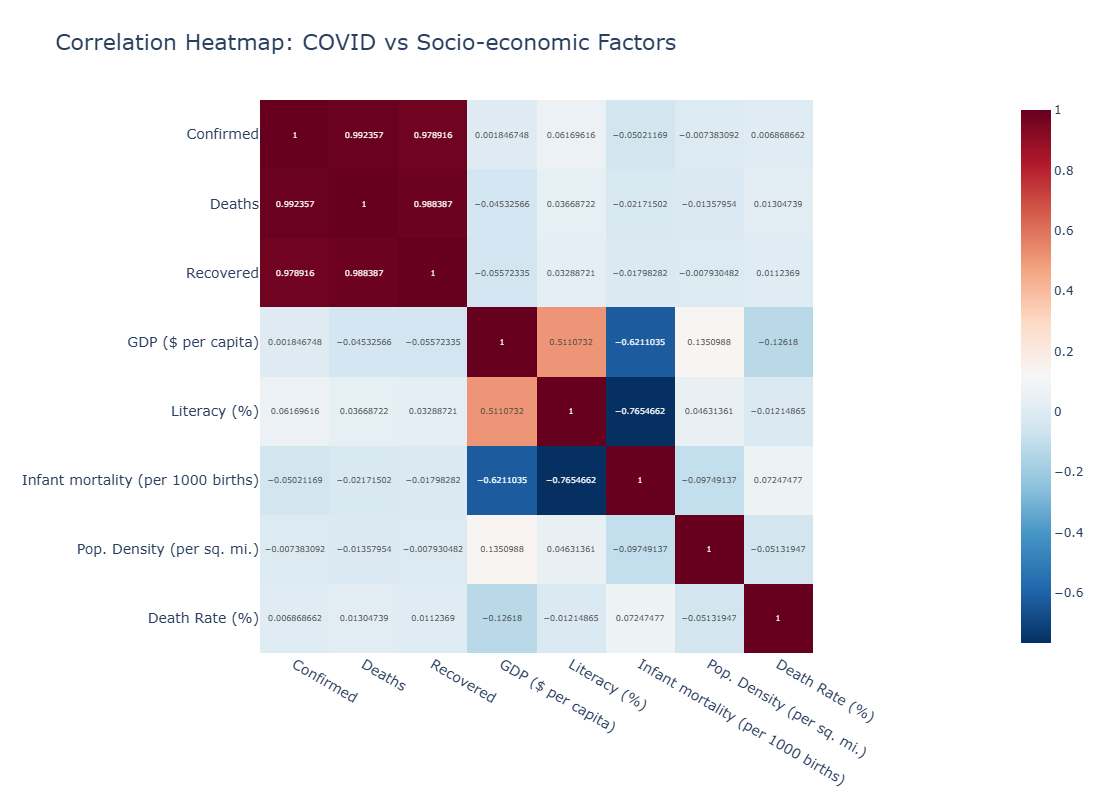

In [79]:
fig_corr = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Heatmap: COVID vs Socio-economic Factors",
    width=1000,  
    height=800    
)

# Update font sizes for better readability
fig_corr.update_layout(
    title_font_size=22,
    xaxis=dict(tickfont=dict(size=14)),
    yaxis=dict(tickfont=dict(size=14))
)

fig_corr.show()

### 📊 Correlation Heatmap Insights: COVID vs Socio-economic Factors

---

#### 🔴 Strong Positive Correlations
1. **Confirmed vs Deaths (0.99)**  
   - Extremely strong positive correlation.  
   - More confirmed cases directly associate with more deaths.  

2. **Confirmed vs Recovered (0.98)**  
   - Strong correlation: more confirmed cases lead to more recoveries.  

3. **Deaths vs Recovered (0.99)**  
   - Strong correlation: deaths are proportional to overall confirmed cases and recoveries.  

---

#### 🔵 Negative Correlations
1. **GDP per capita vs Infant mortality (−0.62)**  
   - Higher GDP countries tend to have lower infant mortality.  

2. **Literacy (%) vs Infant mortality (−0.77)**  
   - Higher literacy strongly correlates with lower infant mortality.  
   - Education is linked to better healthcare and survival outcomes.  

3. **GDP per capita vs Literacy (0.51)**  
   - Moderate positive correlation: wealthier countries often have higher literacy rates.  

---

#### ⚪ Weak / No Significant Correlations
1. **COVID variables vs Socio-economic factors**  
   - Confirmed, Deaths, and Recovered show very weak correlations with GDP, Literacy, Infant Mortality, Population Density, or Death Rate (%).  
   - Example:  
     - Confirmed vs GDP per capita → **0.0018** (almost no relationship).  
     - Death Rate vs GDP per capita → **−0.12** (very weak negative).  

2. **Population Density vs COVID cases**  
   - Weak correlation (−0.007 to 0.135).  
   - Suggests density alone didn’t strongly affect spread (likely due to differences in testing, policies, and healthcare systems).  

---

#### 📌 Key Takeaways
- COVID variables (Confirmed, Deaths, Recovered) are **strongly interrelated**.  
- Socio-economic indicators (GDP, Literacy, Infant Mortality) are **strongly correlated among themselves**.  
- COVID spread and severity were **not strongly linked to socio-economic factors** in this dataset.  
- Death Rate (%) shows **no meaningful correlation** with socio-economic factors, implying pandemic response and healthcare systems may matter more.  


----

### Test if GDP, Literacy, Infant mortality `predict Death Rate`.

In [80]:
X = merged[["GDP ($ per capita)", "Literacy (%)", "Infant mortality (per 1000 births)"]]
y = merged["Death Rate (%)"]

# Add constant term (for regression intercept)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Death Rate (%)   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7793
Date:                Sun, 07 Sep 2025   Prob (F-statistic):              0.508
Time:                        15:53:05   Log-Likelihood:                -442.72
No. Observations:                 110   AIC:                             893.4
Df Residuals:                     106   BIC:                             904.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

#### 📊 OLS Regression Results: Death Rate (%)

---

##### 🔎 Key Findings

- **R-squared = 0.022 (2.2%)**  
  - The model explains only about **2.2% of the variation** in death rates.  
  - This means the predictors (`GDP`, `Literacy`, `Infant mortality`) are **not useful** in explaining COVID death rate (%) in this dataset.  

---

##### 📉 Model Significance

- **F-statistic = 0.779**  
- **p-value = 0.508**  

✅ The F-test checks whether the model as a whole is statistically significant.  
❌ Since **p > 0.05**, the model is **not statistically significant**.  


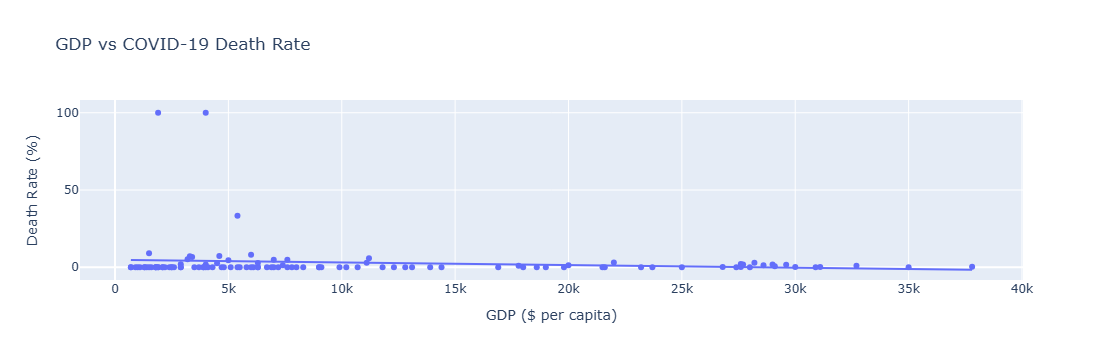

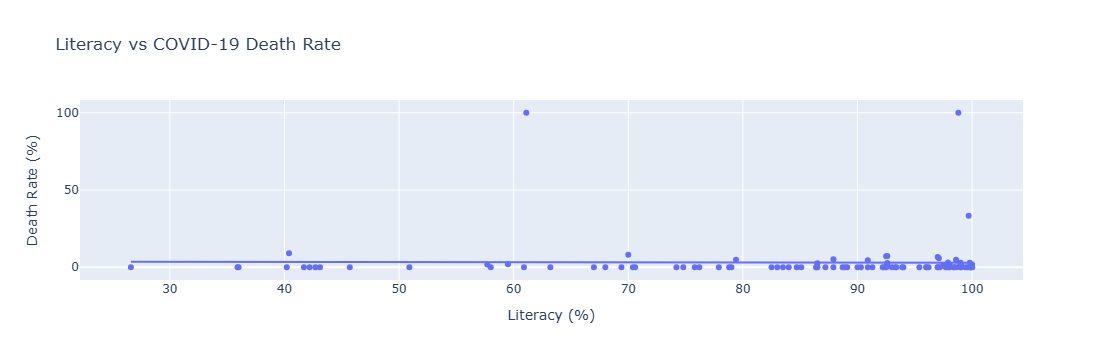

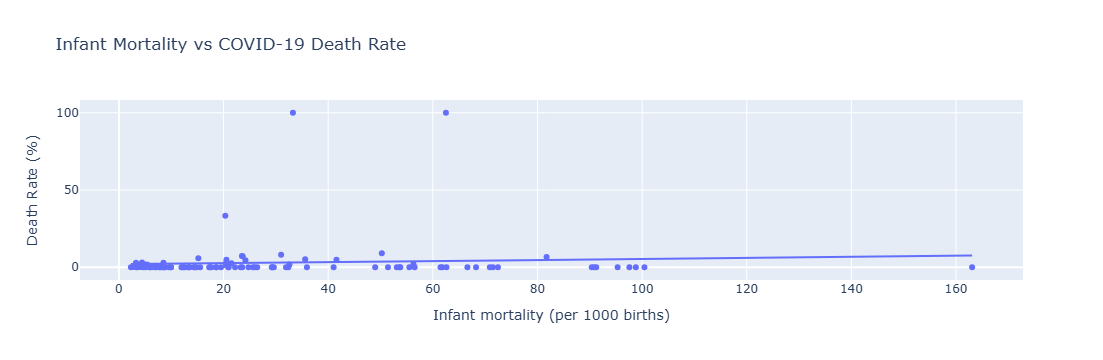

In [81]:
# GDP vs Death Rate
fig_gdp = px.scatter(
    merged,
    x="GDP ($ per capita)",
    y="Death Rate (%)",
    hover_name="Country",
    trendline="ols",
    title="GDP vs COVID-19 Death Rate"
)
fig_gdp.show()

# Literacy vs Death Rate
fig_lit = px.scatter(
    merged,
    x="Literacy (%)",
    y="Death Rate (%)",
    hover_name="Country",
    trendline="ols",
    title="Literacy vs COVID-19 Death Rate"
)
fig_lit.show()

# Infant Mortality vs Death Rate
fig_inf = px.scatter(
    merged,
    x="Infant mortality (per 1000 births)",
    y="Death Rate (%)",
    hover_name="Country",
    trendline="ols",
    title="Infant Mortality vs COVID-19 Death Rate"
)
fig_inf.show()


**As Infant Mortality increase the Death Rate increase**<br>

----

## Highlight trends or anomalies (7-day moving averages, case surges)

### Compute 7-day Moving Averages

In [82]:
Global_7_Days = global_covid.copy()

Global_7_Days["Confirmed_7_Days"] = Global_7_Days["Confirmed"].rolling(7).mean()
Global_7_Days["Deaths_7_Days"] = Global_7_Days["Deaths"].rolling(7).mean()
Global_7_Days["Recovered_7_Dayes"] = Global_7_Days["Recovered"].rolling(7).mean()

### Surge threshold (1.5x the 7-day mean)

In [83]:
Global_7_Days["Confirmed_Daily"] = Global_7_Days["Confirmed"].diff()
Global_7_Days["Deaths_Daily"] = Global_7_Days["Deaths"].diff()
Global_7_Days["Recovered_Daily"] = Global_7_Days["Recovered"].diff()

Global_7_Days["Confirmed_Surge"] = Global_7_Days["Confirmed_Daily"] > (1.5 * Global_7_Days["Confirmed_Daily"].rolling(7).mean())

### Plot Covid Trends (7-day moving averages)

In [84]:
def plot_covid_trends(Global_7_Days):
    # Ensure sorted by Date
    Global_7_Days = Global_7_Days.sort_index()

    # Daily new cases
    Global_7_Days["Confirmed_Daily"] = Global_7_Days["Confirmed"].diff()
    Global_7_Days["Confirmed_MA7"] = Global_7_Days["Confirmed_Daily"].rolling(7).mean()

    # Surge detection (1.5x 7-day MA)
    Global_7_Days["Confirmed_Surge"] = Global_7_Days["Confirmed_Daily"] > (
        1.5 * Global_7_Days["Confirmed_Daily"].rolling(7).mean()
    )

    fig = go.Figure()

    # Daily confirmed
    fig.add_trace(go.Scatter(
        x=Global_7_Days.index,
        y=Global_7_Days["Confirmed_Daily"],
        mode="lines",
        name="Daily Confirmed",
        line=dict(color="blue"),
        opacity=0.5
    ))

    # 7-day moving average
    fig.add_trace(go.Scatter(
        x=Global_7_Days.index,
        y=Global_7_Days["Confirmed_MA7"],
        mode="lines",
        name="7-day MA",
        line=dict(color="red", width=2)
    ))

    # Highlight surges
    fig.add_trace(go.Scatter(
        x=Global_7_Days.index[Global_7_Days["Confirmed_Surge"]],
        y=Global_7_Days["Confirmed_Daily"][Global_7_Days["Confirmed_Surge"]],
        mode="markers",
        name="Surge",
        marker=dict(color="orange", size=10, symbol="circle")
    ))

    fig.update_layout(
        title="COVID Confirmed Cases: Daily, 7-day MA & Surges",
        xaxis_title="Date",
        yaxis_title="Cases",
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()


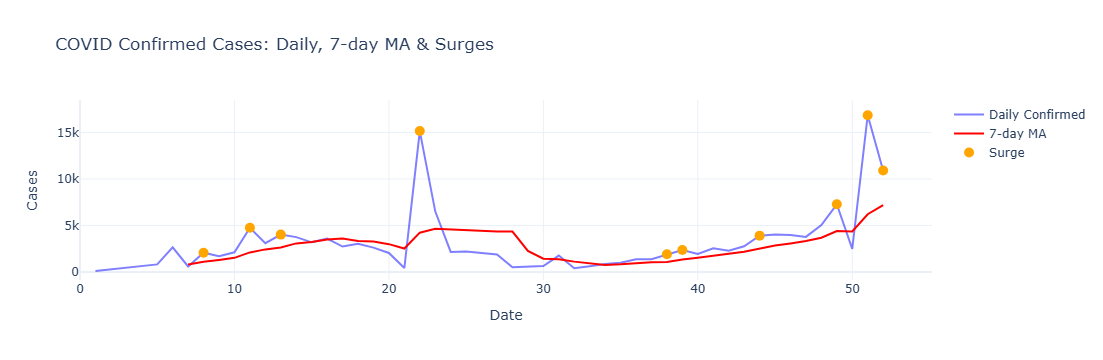

In [85]:
plot_covid_trends(Global_7_Days)


----

## Splitting Data

In [86]:
train_size = int(len(global_covid) * 0.8)
train, test = global_covid.iloc[:train_size], global_covid.iloc[train_size:]

----

## Prophet Model

In [87]:
prophet_train = train.reset_index()[["Date", "Confirmed"]].rename(columns={"Date":"ds", "Confirmed":"y"})
prophet_test = test.reset_index()[["Date", "Confirmed"]].rename(columns={"Date":"ds", "Confirmed":"y"})

model_prophet = Prophet()
model_prophet.fit(prophet_train)

future = pd.concat([prophet_train[["ds"]], prophet_test[["ds"]]])
forecast = model_prophet.predict(future)

forecast_prophet = forecast.iloc[-len(prophet_test):]["yhat"].values

# Prophet metrics
mae_prophet = mean_absolute_error(prophet_test["y"], forecast_prophet)
rmse_prophet = np.sqrt(mean_squared_error(prophet_test["y"], forecast_prophet))
mape_prophet = np.mean(np.abs((prophet_test["y"].values - forecast_prophet) / prophet_test["y"].values)) * 100
r2_prophet = r2_score(prophet_test["y"], forecast_prophet)

15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:06 - cmdstanpy - INFO - Chain [1] done processing


## Evaluate Model

In [88]:
results = pd.DataFrame({
    "Model": ["Prophet"],
    "MAE": [mae_prophet],
    "RMSE": [rmse_prophet],
    "MAPE %": [mape_prophet],
    "R²": [r2_prophet]
})

print(results)

     Model           MAE          RMSE   MAPE %       R²
0  Prophet  10849.195523  15543.507511  8.12931  0.29822


## Plot Actual vs Prophet Forecast

In [89]:
def plot_prophet_interactive(series_train, series_test, forecast_prophet):
    fig = go.Figure()

    # Training data
    fig.add_trace(go.Scatter(
        x=series_train.index, 
        y=series_train.values,
        mode='lines',
        name='Train',
        line=dict(color='blue')
    ))

    # Test (actual) data
    fig.add_trace(go.Scatter(
        x=series_test.index, 
        y=series_test.values,
        mode='lines',
        name='Test (Actual)',
        line=dict(color='black')
    ))

    # Prophet forecast
    fig.add_trace(go.Scatter(
        x=series_test.index, 
        y=forecast_prophet,
        mode='lines',
        name='Prophet Forecast',
        line=dict(color='green', dash='dash')
    ))

    # Layout
    fig.update_layout(
        title="COVID Confirmed Cases: Actual vs Prophet Forecast",
        xaxis_title="Date",
        yaxis_title="Confirmed Cases",
        template="plotly_white",
        hovermode="x unified",
        height= 700,
        width = 1000
    )

    fig.show()


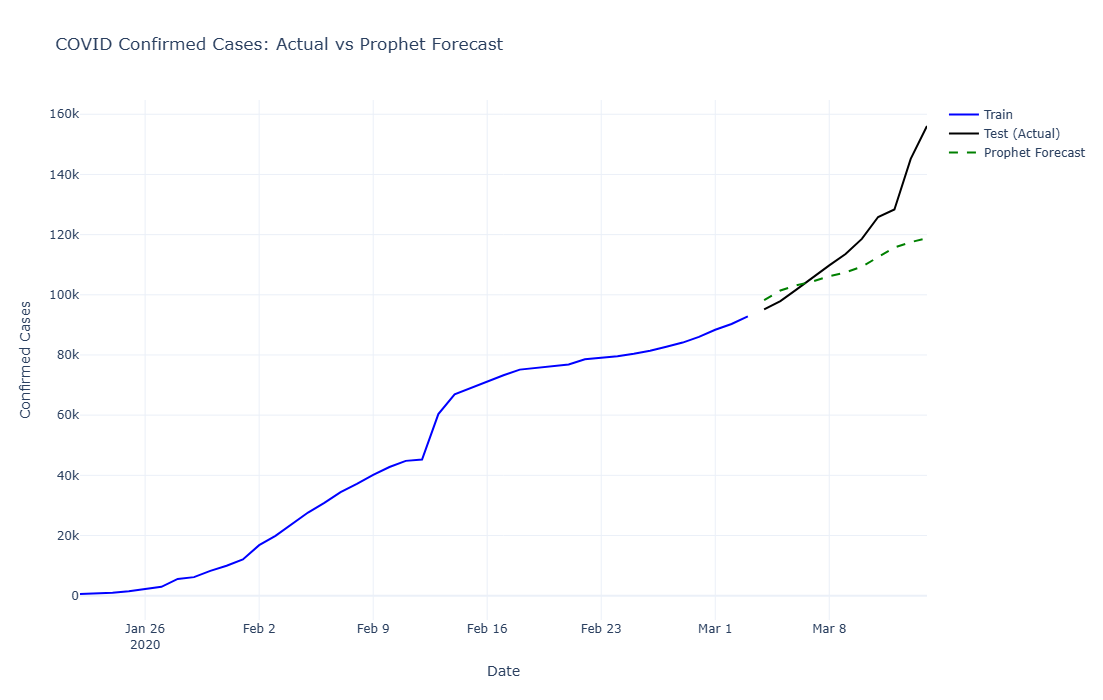

In [90]:
plot_prophet_interactive(
    prophet_train.set_index("ds")["y"],   # train series
    prophet_test.set_index("ds")["y"],    # test series
    forecast_prophet                      # Prophet forecast values
)

## Train Prophet with many parameter combinations

In [91]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
}

# Generate combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Store results
results = []

for params in all_params:
    # Train model
    model = Prophet(**params)
    model.fit(prophet_train)

    # Forecast on test period
    future = pd.concat([prophet_train[["ds"]], prophet_test[["ds"]]])
    forecast = model.predict(future)
    forecast_prophet = forecast.iloc[-len(prophet_test):]["yhat"].values

    # Evaluate
    mae = mean_absolute_error(prophet_test["y"], forecast_prophet)
    rmse = np.sqrt(mean_squared_error(prophet_test["y"], forecast_prophet))
    mape = np.mean(np.abs((prophet_test["y"].values - forecast_prophet) / prophet_test["y"].values)) * 100
    r2 = r2_score(prophet_test["y"], forecast_prophet)

    results.append({
        **params,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R²": r2
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("R²", ascending=False)

print(results_df.head())

15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1] done processing
15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1] done processing
15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  weekly_seasonality  \
58                      1.0                       10               False   
54                      1.0                        5               False   
60                      1.0                       20                True   
50                      1.0                        1               False   
62                      1.0                       20               False   

    yearly_seasonality          MAE         RMSE      MAPE        R²  
58                True  3463.008326  4351.047832  2.713313  0.945009  
54                True  3252.933699  4664.312838  2.476323  0.936806  
60                True  4504.653569  5559.161568  3.567383  0.910232  
50                True  3438.168057  6596.431262  2.444474  0.873608  
62                True  4534.785839  8360.257828  3.257646  0.796978  


## Retrain Model with best_params discovered

In [92]:
# Pick the best parameters (highest R²)
best_params = results_df.iloc[0][['changepoint_prior_scale', 'seasonality_prior_scale', 
                                  'weekly_seasonality', 'yearly_seasonality']].to_dict()

print("Best Parameters:", best_params)

# Retrain Prophet on training set with best params
best_model = Prophet(**best_params)
best_model.fit(prophet_train)

# Forecast on test set
future = pd.concat([prophet_train[["ds"]], prophet_test[["ds"]]])
forecast = best_model.predict(future)

# Extract only test predictions
y_pred = forecast.iloc[-len(prophet_test):]["yhat"].values
y_true = prophet_test["y"].values

# Final evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)



15:53:30 - cmdstanpy - INFO - Chain [1] start processing


Best Parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10, 'weekly_seasonality': False, 'yearly_seasonality': True}


15:53:30 - cmdstanpy - INFO - Chain [1] done processing


## Final Evaluation

In [93]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Final Best Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

Final Best Model Evaluation:
MAE: 3463.01
RMSE: 4351.05
R²: 0.9450
MAPE: 2.71%


-------

# Deplyment of Dashboard

https://covid-19-deploy.streamlit.app/

---